# LSTM System Identification: Three Tanks System

In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import optuna
from optuna.samplers import TPESampler

import keras
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model,load_model

## Load the Data Set

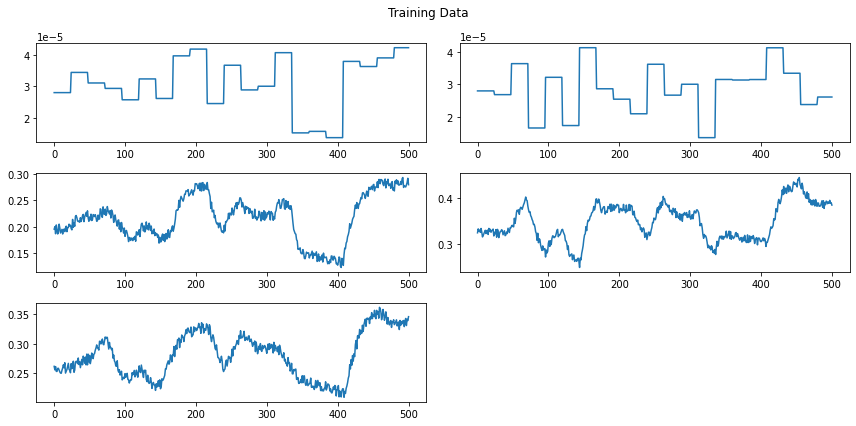

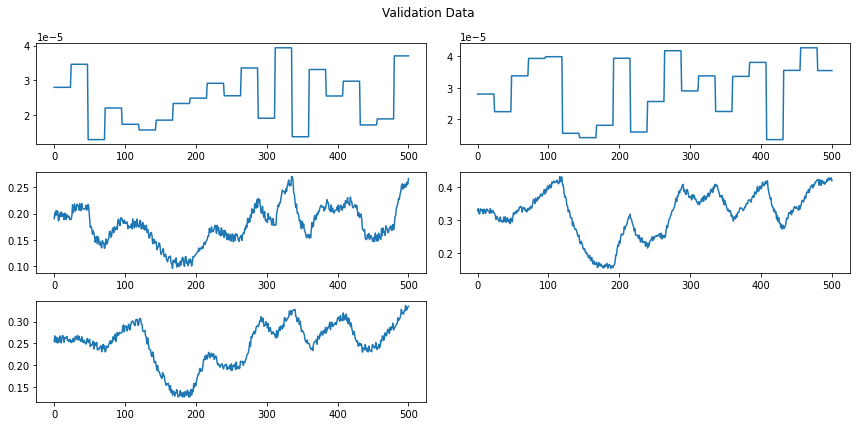

(501, 5)
(501, 5)


In [3]:
tanks_df = pd.read_csv('tanks_seed1_in.csv', index_col=0)
tanks_df2 = pd.read_csv('tanks_seed0_in.csv', index_col=0)

v_name = ['u1', 'u2', 'x1', 'x2', 'x3']
noise_var = np.array([0, 0, 0.02, 0.02, 0.02])

np.random.seed(0)

def prepare_and_plot(tanks_df, noise_var, label):
    plt.figure(figsize=(12, 6))
    ctr = 1
    res = list()
    for j in range(len(v_name)):
        plt.subplot(3,2,ctr)
        data = tanks_df[v_name[j]].values
        data += (np.random.rand(len(data))-0.5)*noise_var[j]
        res.append(data)
        plt.plot(data)
        ctr += 1

    plt.suptitle(label)
    plt.tight_layout()
    plt.show()
    
    return np.transpose(np.vstack(res))

Z_train = prepare_and_plot(tanks_df, noise_var, 'Training Data')
Z_valid = prepare_and_plot(tanks_df2, noise_var, 'Validation Data')
print(Z_train.shape)
print(Z_valid.shape)

In [4]:
YI, UI = np.array([2, 3, 4]), np.array([0, 1])

sc = StandardScaler()
Z_train_sc = sc.fit_transform(Z_train)
Z_valid_sc = sc.transform(Z_valid)

# LSTM Input:  Both [u_k, y_(k-1)] data for time steps k := [k, k+look_back-1]
# LSTM Output: Only [y_k] data for time steps k := [k, k+look_back-1]

look_back = 23
UY_train, Y_train = [], []
UY_valid, Y_valid = [], []

for k in range(1, len(Z_train)-look_back+1):
    UY_train.append(np.hstack((Z_train_sc[k:k+look_back, UI], 
                               Z_train_sc[k-1:k+look_back-1, YI])))
    Y_train.append(Z_train_sc[k:k+look_back, YI])
                    
    UY_valid.append(np.hstack((Z_valid_sc[k:k+look_back, UI], 
                               Z_valid_sc[k-1:k+look_back-1, YI])))
    Y_valid.append(Z_valid_sc[k:k+look_back, YI])

UY_train_ = np.stack(UY_train, axis=0)
Y_train_ = np.stack(Y_train, axis=0)
UY_valid_ = np.stack(UY_valid, axis=0)
Y_valid_ = np.stack(Y_valid, axis=0)

print(sc.scale_)
print(sc.mean_)

print(UY_train_.shape)
print(Y_train_.shape)
print(UY_valid_.shape)
print(Y_valid_.shape)

[8.46453479e-06 7.29156132e-06 4.23092551e-02 4.05435287e-02
 3.80664313e-02]
[3.08757950e-05 2.85512014e-05 2.16306891e-01 3.47345648e-01
 2.80801000e-01]
(478, 23, 5)
(478, 23, 3)
(478, 23, 5)
(478, 23, 3)


## Make a trial LSTM then evaluate

Ident time: 8.66 sec


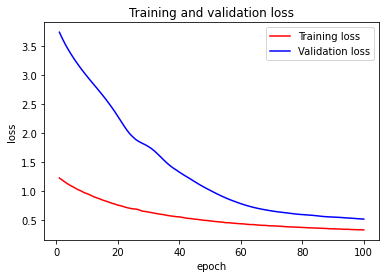

In [5]:
keras.utils.set_random_seed(42)

start = time()
model = Sequential()

reg_value = 0.01
model.add(LSTM(15,
               activation='relu',
               kernel_regularizer=l2(reg_value), 
               recurrent_regularizer=l2(reg_value), 
               bias_regularizer=l2(reg_value),
               dropout=0.2,
               recurrent_dropout=0.2,
               return_sequences=True))
model.add(Dense(3, 
                activation='linear',
                kernel_regularizer=l2(reg_value),
                bias_regularizer=l2(reg_value)))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(UY_train_, Y_train_,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.1, 
                    verbose=0)

print(f'Ident time: {time() - start:.2f} sec')
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

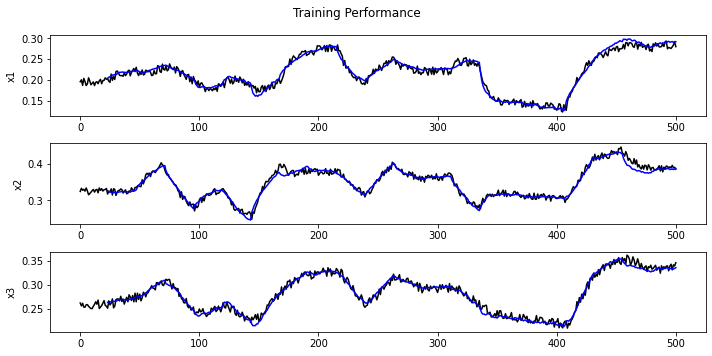

Training Performance: 
 x1 fitness: 96.247%
 x2 fitness: 95.620%
 x3 fitness: 96.584%
 Average:    96.150%
 Sim time:   0.08 sec


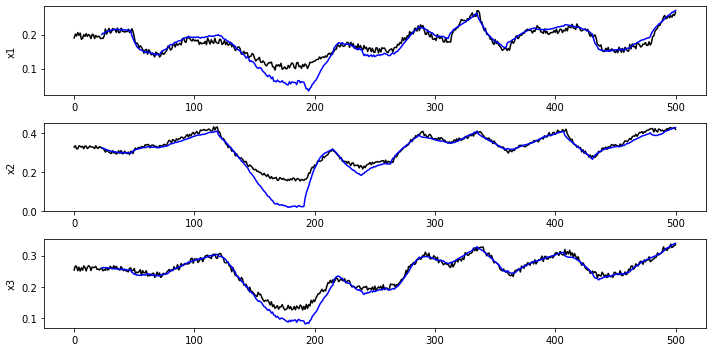

 x1 fitness: 72.974%
 x2 fitness: 71.359%
 x3 fitness: 90.844%
 Average:    78.392%
 Sim time:   0.08 sec


In [8]:
def R2_score(Z, y_pred):
    r2 = np.zeros(len(YI))
    for k in range(len(YI)):
        y_true = Z[look_back:, YI[k]]
        r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                / np.sum((y_true - np.mean(y_true)) ** 2)
    return r2

start = time()
y = model.predict(UY_train_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

# Plot for Training Data
plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_train)), Z_train[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+2])
    #plt.xlim([0, 200])

plt.suptitle('Training Performance')
plt.tight_layout()
plt.show()

r2 = R2_score(Z_train, y_)
print('Training Performance: ')
print(f" x1 fitness: {r2[0]*100:.3f}%")
print(f" x2 fitness: {r2[1]*100:.3f}%")
print(f" x3 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

# Plot for Validation Data
start = time()
y = model.predict(UY_valid_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_valid)), Z_valid[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+2])
    #plt.xlim([0, 200])

plt.tight_layout()
plt.show()

r2 = R2_score(Z_valid, y_)
print(f" x1 fitness: {r2[0]*100:.3f}%")
print(f" x2 fitness: {r2[1]*100:.3f}%")
print(f" x3 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

## Use Optuna to tune an LSTM

In [9]:
def create_model(trial):
    
    keras.utils.set_random_seed(42)
    
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
    activation = trial.suggest_categorical("lstm_activation", ["tanh", "linear", "relu"])
    batchsize = trial.suggest_int("batchsize", 3, 8, step=1, log=False) # 2^3 to 2^8
    rec_dropout = trial.suggest_float("rec_dropout", 0, 0.5, step=0.1)
    dropout = trial.suggest_float("dropout", 0, 0.5, step=0.1)
    lstm_units = trial.suggest_int("lstm_units", 5, 40, step=1)
    reg_value = trial.suggest_float("reg_value", 0.01, 1, log=True)
    
    start = time()
    model = Sequential()
    model.add(LSTM(units=lstm_units,
                   activation=activation,
                   kernel_regularizer=l2(reg_value), 
                   recurrent_regularizer=l2(reg_value), 
                   bias_regularizer=l2(reg_value),
                   dropout=dropout,
                   recurrent_dropout=rec_dropout,
                   return_sequences=True))
    model.add(Dense(3, 
                    activation='linear',
                    kernel_regularizer=l2(reg_value),
                    bias_regularizer=l2(reg_value)))
    model.compile(optimizer=optimizer_name, loss='mean_squared_error')
    history = model.fit(UY_train_, Y_train_, 
                        epochs=100,
                        batch_size=2**batchsize,
                        validation_split=0.1,
                        verbose=0)
    
    print(f'Ident time: {time() - start:.2f} sec')
    
    if trial.should_prune():
            raise optuna.TrialPruned()
    
    return model

def objective(trial):
    
    model = create_model(trial)
    
    sim_time = time()
    y = model.predict(UY_valid_, verbose=0)
    y_pred = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
    sim_time = time() - sim_time
    print(f" Sim time:   {sim_time:.2f} sec")
    
    r2 = np.zeros(len(YI))
    for k in range(len(YI)):
        y_true = Z_valid[look_back:, YI[k]]
        r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                / np.sum((y_true - np.mean(y_true)) ** 2)   
    
    return np.mean(r2)

sampler = TPESampler(seed=42)
best_mdl, best_study = [], []
study = optuna.create_study(direction='maximize', 
                            sampler=sampler)
optuna_start = time()
study.optimize(lambda trial: objective(trial), n_trials=100)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)
total_time = time()-optuna_start
print("Runtime: %.4f sec" % total_time)

[I 2025-05-23 13:13:03,590] A new study created in memory with name: no-name-05042d69-6b1c-40bc-acf6-7c0cca2d3074


Ident time: 6.72 sec


[I 2025-05-23 13:13:10,643] Trial 0 finished with value: -0.4806242923602921 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.30000000000000004, 'dropout': 0.4, 'lstm_units': 5, 'reg_value': 0.8706020878304853}. Best is trial 0 with value: -0.4806242923602921.


 Sim time:   0.29 sec
Ident time: 23.15 sec


[I 2025-05-23 13:13:34,113] Trial 1 finished with value: -57.49517597214581 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.30000000000000004, 'dropout': 0.0, 'lstm_units': 15, 'reg_value': 0.05404103854647329}. Best is trial 0 with value: -0.4806242923602921.


 Sim time:   0.31 sec
Ident time: 17.69 sec


[I 2025-05-23 13:13:52,074] Trial 2 finished with value: -0.45131701613188874 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.0, 'dropout': 0.5, 'lstm_units': 39, 'reg_value': 0.4138040112561014}. Best is trial 2 with value: -0.45131701613188874.


 Sim time:   0.25 sec
Ident time: 7.26 sec


[I 2025-05-23 13:13:59,651] Trial 3 finished with value: 0.6382017025916643 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.30000000000000004, 'lstm_units': 16, 'reg_value': 0.10968217207529521}. Best is trial 3 with value: 0.6382017025916643.


 Sim time:   0.31 sec
Ident time: 6.57 sec


[I 2025-05-23 13:14:06,658] Trial 4 finished with value: 0.35430376092254834 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 6, 'reg_value': 0.04473636174621265}. Best is trial 3 with value: 0.6382017025916643.


 Sim time:   0.41 sec
Ident time: 6.91 sec


[I 2025-05-23 13:14:13,865] Trial 5 finished with value: 0.8964567662127204 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.5, 'lstm_units': 32, 'reg_value': 0.024970737145052727}. Best is trial 5 with value: 0.8964567662127204.


 Sim time:   0.27 sec
Ident time: 47.06 sec


[I 2025-05-23 13:15:01,255] Trial 6 finished with value: 0.6736423413445918 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'tanh', 'batchsize': 3, 'rec_dropout': 0.5, 'dropout': 0.30000000000000004, 'lstm_units': 16, 'reg_value': 0.0134003672433548}. Best is trial 5 with value: 0.8964567662127204.


 Sim time:   0.34 sec
Ident time: 10.18 sec


[I 2025-05-23 13:15:11,784] Trial 7 finished with value: 0.6194038828573059 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 7, 'rec_dropout': 0.4, 'dropout': 0.30000000000000004, 'lstm_units': 32, 'reg_value': 0.09718319944817398}. Best is trial 5 with value: 0.8964567662127204.


 Sim time:   0.34 sec
Ident time: 11.07 sec


[I 2025-05-23 13:15:23,164] Trial 8 finished with value: -588.3212521366903 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.5, 'dropout': 0.1, 'lstm_units': 19, 'reg_value': 0.3244160088734159}. Best is trial 5 with value: 0.8964567662127204.


 Sim time:   0.31 sec
Ident time: 9.01 sec


[I 2025-05-23 13:15:32,541] Trial 9 finished with value: 0.6179526763767714 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.4, 'dropout': 0.1, 'lstm_units': 37, 'reg_value': 0.1198628179990118}. Best is trial 5 with value: 0.8964567662127204.


 Sim time:   0.35 sec
Ident time: 11.76 sec


[I 2025-05-23 13:15:44,703] Trial 10 finished with value: -0.3202116527057478 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.1, 'dropout': 0.5, 'lstm_units': 28, 'reg_value': 0.010744583847151153}. Best is trial 5 with value: 0.8964567662127204.


 Sim time:   0.33 sec
Ident time: 51.81 sec


[I 2025-05-23 13:16:36,958] Trial 11 finished with value: 0.9555716464761268 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.2, 'dropout': 0.4, 'lstm_units': 27, 'reg_value': 0.011657335780160467}. Best is trial 11 with value: 0.9555716464761268.


 Sim time:   0.41 sec
Ident time: 17.88 sec


[I 2025-05-23 13:16:55,424] Trial 12 finished with value: -0.18854346645076514 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.2, 'dropout': 0.4, 'lstm_units': 28, 'reg_value': 0.020460251674727474}. Best is trial 11 with value: 0.9555716464761268.


 Sim time:   0.54 sec
Ident time: 49.34 sec


[I 2025-05-23 13:17:45,133] Trial 13 finished with value: 0.9182888291545052 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.1, 'dropout': 0.4, 'lstm_units': 26, 'reg_value': 0.02010616275099409}. Best is trial 11 with value: 0.9555716464761268.


 Sim time:   0.32 sec
Ident time: 47.79 sec


[I 2025-05-23 13:18:33,293] Trial 14 finished with value: 0.9591338652774807 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.2, 'dropout': 0.4, 'lstm_units': 24, 'reg_value': 0.011383400064639334}. Best is trial 14 with value: 0.9591338652774807.


 Sim time:   0.33 sec
Ident time: 27.04 sec


[I 2025-05-23 13:19:00,752] Trial 15 finished with value: 0.968571543244813 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 22, 'reg_value': 0.011038072899991286}. Best is trial 15 with value: 0.968571543244813.


 Sim time:   0.37 sec
Ident time: 28.09 sec


[I 2025-05-23 13:19:29,199] Trial 16 finished with value: 0.9686283070630971 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 22, 'reg_value': 0.010519095028133847}. Best is trial 16 with value: 0.9686283070630971.


 Sim time:   0.33 sec
Ident time: 28.73 sec


[I 2025-05-23 13:19:58,290] Trial 17 finished with value: -71.98913884984597 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.30000000000000004, 'dropout': 0.2, 'lstm_units': 21, 'reg_value': 0.030134703715443627}. Best is trial 16 with value: 0.9686283070630971.


 Sim time:   0.33 sec
Ident time: 18.93 sec


[I 2025-05-23 13:20:17,567] Trial 18 finished with value: 0.9567557442975589 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 12, 'reg_value': 0.018727124205111724}. Best is trial 16 with value: 0.9686283070630971.


 Sim time:   0.31 sec
Ident time: 17.18 sec


[I 2025-05-23 13:20:35,094] Trial 19 finished with value: 0.45947202840328843 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.1, 'dropout': 0.2, 'lstm_units': 10, 'reg_value': 0.03603086451237455}. Best is trial 16 with value: 0.9686283070630971.


 Sim time:   0.31 sec
Ident time: 27.65 sec


[I 2025-05-23 13:21:03,111] Trial 20 finished with value: -0.7078273055556593 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'relu', 'batchsize': 4, 'rec_dropout': 0.4, 'dropout': 0.1, 'lstm_units': 21, 'reg_value': 0.01722693994422326}. Best is trial 16 with value: 0.9686283070630971.


 Sim time:   0.33 sec
Ident time: 49.48 sec


[I 2025-05-23 13:21:52,957] Trial 21 finished with value: 0.9663255454826567 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 3, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 24, 'reg_value': 0.010999574575771248}. Best is trial 16 with value: 0.9686283070630971.


 Sim time:   0.33 sec
Ident time: 27.72 sec


[I 2025-05-23 13:22:21,044] Trial 22 finished with value: 0.9686676311722392 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 23, 'reg_value': 0.010774732739025987}. Best is trial 22 with value: 0.9686676311722392.


 Sim time:   0.33 sec
Ident time: 26.16 sec


[I 2025-05-23 13:22:47,582] Trial 23 finished with value: 0.9678011269132673 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.30000000000000004, 'dropout': 0.2, 'lstm_units': 19, 'reg_value': 0.016447526385177436}. Best is trial 22 with value: 0.9686676311722392.


 Sim time:   0.34 sec
Ident time: 16.87 sec


[I 2025-05-23 13:23:04,808] Trial 24 finished with value: 0.9640177905824888 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 32, 'reg_value': 0.028050351434174045}. Best is trial 22 with value: 0.9686676311722392.


 Sim time:   0.33 sec
Ident time: 26.64 sec


[I 2025-05-23 13:23:31,810] Trial 25 finished with value: 0.9660865224508471 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.2, 'dropout': 0.30000000000000004, 'lstm_units': 19, 'reg_value': 0.01534828419663997}. Best is trial 22 with value: 0.9686676311722392.


 Sim time:   0.34 sec
Ident time: 16.66 sec


[I 2025-05-23 13:23:48,869] Trial 26 finished with value: 0.9648861453482062 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 5, 'rec_dropout': 0.30000000000000004, 'dropout': 0.1, 'lstm_units': 23, 'reg_value': 0.014619632868964077}. Best is trial 22 with value: 0.9686676311722392.


 Sim time:   0.37 sec
Ident time: 28.78 sec


[I 2025-05-23 13:24:18,029] Trial 27 finished with value: 0.9573887693864483 and parameters: {'optimizer': 'SGD', 'lstm_activation': 'linear', 'batchsize': 4, 'rec_dropout': 0.1, 'dropout': 0.2, 'lstm_units': 25, 'reg_value': 0.0233453622498245}. Best is trial 22 with value: 0.9686676311722392.


 Sim time:   0.34 sec
Ident time: 12.47 sec


[I 2025-05-23 13:24:31,097] Trial 28 finished with value: 0.9721161182211852 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.30000000000000004, 'lstm_units': 30, 'reg_value': 0.010497138286016281}. Best is trial 28 with value: 0.9721161182211852.


 Sim time:   0.56 sec
Ident time: 13.85 sec


[I 2025-05-23 13:24:45,341] Trial 29 finished with value: 0.4076936275486902 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.30000000000000004, 'lstm_units': 30, 'reg_value': 0.01552211628342935}. Best is trial 28 with value: 0.9721161182211852.


 Sim time:   0.36 sec
Ident time: 11.26 sec


[I 2025-05-23 13:24:57,247] Trial 30 finished with value: 0.74894984106664 and parameters: {'optimizer': 'adam', 'lstm_activation': 'tanh', 'batchsize': 7, 'rec_dropout': 0.4, 'dropout': 0.30000000000000004, 'lstm_units': 36, 'reg_value': 0.03604681624586642}. Best is trial 28 with value: 0.9721161182211852.


 Sim time:   0.62 sec
Ident time: 12.00 sec


[I 2025-05-23 13:25:09,625] Trial 31 finished with value: 0.9748720265525778 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 22, 'reg_value': 0.010260145134912019}. Best is trial 31 with value: 0.9748720265525778.


 Sim time:   0.34 sec
Ident time: 11.91 sec


[I 2025-05-23 13:25:21,895] Trial 32 finished with value: 0.9751345469850833 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.2, 'dropout': 0.2, 'lstm_units': 30, 'reg_value': 0.010148234251849152}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.33 sec
Ident time: 12.91 sec


[I 2025-05-23 13:25:35,166] Trial 33 finished with value: 0.9677828824436889 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.30000000000000004, 'dropout': 0.30000000000000004, 'lstm_units': 35, 'reg_value': 0.014151398678609078}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.33 sec
Ident time: 9.71 sec


[I 2025-05-23 13:25:45,232] Trial 34 finished with value: 0.9722016783374116 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.2, 'dropout': 0.0, 'lstm_units': 30, 'reg_value': 0.022590752590059653}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.30 sec
Ident time: 9.85 sec


[I 2025-05-23 13:25:55,408] Trial 35 finished with value: 0.9731571033076595 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 30, 'reg_value': 0.021185343192213178}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.31 sec
Ident time: 7.15 sec


[I 2025-05-23 13:26:02,854] Trial 36 finished with value: 0.9713979650581409 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 30, 'reg_value': 0.023735616449314982}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.26 sec
Ident time: 10.56 sec


[I 2025-05-23 13:26:13,820] Trial 37 finished with value: 0.9738402970629716 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 40, 'reg_value': 0.02038691964370741}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.38 sec
Ident time: 8.05 sec


[I 2025-05-23 13:26:22,345] Trial 38 finished with value: 0.7231439271045358 and parameters: {'optimizer': 'adam', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 39, 'reg_value': 0.051492665865076934}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.44 sec
Ident time: 11.01 sec


[I 2025-05-23 13:26:33,731] Trial 39 finished with value: 0.7994720274875645 and parameters: {'optimizer': 'adam', 'lstm_activation': 'relu', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 40, 'reg_value': 0.013729499114360643}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.34 sec
Ident time: 8.25 sec


[I 2025-05-23 13:26:42,256] Trial 40 finished with value: 0.9563628830415856 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 6, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 34, 'reg_value': 0.030921699663215504}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.25 sec
Ident time: 10.11 sec


[I 2025-05-23 13:26:52,741] Trial 41 finished with value: 0.9745563192834953 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 33, 'reg_value': 0.021590582691682972}. Best is trial 32 with value: 0.9751345469850833.


 Sim time:   0.34 sec
Ident time: 10.75 sec


[I 2025-05-23 13:27:03,917] Trial 42 finished with value: 0.975557047788746 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 38, 'reg_value': 0.018914490918614694}. Best is trial 42 with value: 0.975557047788746.


 Sim time:   0.39 sec
Ident time: 10.25 sec


[I 2025-05-23 13:27:14,547] Trial 43 finished with value: 0.9763283144555804 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 38, 'reg_value': 0.017092285586156462}. Best is trial 43 with value: 0.9763283144555804.


 Sim time:   0.34 sec
Ident time: 9.72 sec


[I 2025-05-23 13:27:24,626] Trial 44 finished with value: 0.971302685191592 and parameters: {'optimizer': 'adam', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 37, 'reg_value': 0.013858621639972571}. Best is trial 43 with value: 0.9763283144555804.


 Sim time:   0.32 sec
Ident time: 8.65 sec


[I 2025-05-23 13:27:33,844] Trial 45 finished with value: 0.7750045060620758 and parameters: {'optimizer': 'adam', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.016849272710961222}. Best is trial 43 with value: 0.9763283144555804.


 Sim time:   0.52 sec
Ident time: 10.11 sec


[I 2025-05-23 13:27:44,392] Trial 46 finished with value: 0.97494642052328 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 37, 'reg_value': 0.013186971279202498}. Best is trial 43 with value: 0.9763283144555804.


 Sim time:   0.40 sec
Ident time: 10.92 sec


[I 2025-05-23 13:27:55,683] Trial 47 finished with value: 0.9748572089237987 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 37, 'reg_value': 0.01314371783281154}. Best is trial 43 with value: 0.9763283144555804.


 Sim time:   0.33 sec
Ident time: 6.99 sec


[I 2025-05-23 13:28:02,978] Trial 48 finished with value: 0.9799235283256945 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 38, 'reg_value': 0.01003448732517231}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.27 sec
Ident time: 7.37 sec


[I 2025-05-23 13:28:10,659] Trial 49 finished with value: 0.9786394734581633 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 38, 'reg_value': 0.013349941763053546}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.26 sec
Ident time: 8.57 sec


[I 2025-05-23 13:28:19,739] Trial 50 finished with value: 0.8092894919621213 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 38, 'reg_value': 0.017289577931143878}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.47 sec
Ident time: 7.42 sec


[I 2025-05-23 13:28:27,464] Trial 51 finished with value: 0.9779909630947135 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 35, 'reg_value': 0.013607174615408881}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.26 sec
Ident time: 7.54 sec


[I 2025-05-23 13:28:35,299] Trial 52 finished with value: 0.9752137568053648 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 39, 'reg_value': 0.018450157225879216}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.27 sec
Ident time: 7.36 sec


[I 2025-05-23 13:28:42,959] Trial 53 finished with value: 0.9687956643754143 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 39, 'reg_value': 0.0268970713701181}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.26 sec
Ident time: 6.71 sec


[I 2025-05-23 13:28:49,953] Trial 54 finished with value: 0.9748576915186131 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 35, 'reg_value': 0.018705340583540783}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.25 sec
Ident time: 7.02 sec


[I 2025-05-23 13:28:57,255] Trial 55 finished with value: 0.9791431644596876 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 38, 'reg_value': 0.012346370962712534}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.25 sec
Ident time: 7.22 sec


[I 2025-05-23 13:29:04,817] Trial 56 finished with value: 0.9455162242624923 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 35, 'reg_value': 0.01267437749358165}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.30 sec
Ident time: 7.86 sec


[I 2025-05-23 13:29:12,997] Trial 57 finished with value: 0.9776581103199994 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 36, 'reg_value': 0.012808410377019411}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.26 sec
Ident time: 7.57 sec


[I 2025-05-23 13:29:20,880] Trial 58 finished with value: 0.9782954061599926 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 36, 'reg_value': 0.012725286509155045}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.28 sec
Ident time: 7.93 sec


[I 2025-05-23 13:29:29,091] Trial 59 finished with value: 0.9780465578764806 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 36, 'reg_value': 0.011817002769517047}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.23 sec
Ident time: 7.91 sec


[I 2025-05-23 13:29:37,407] Trial 60 finished with value: 0.9791556443061517 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 34, 'reg_value': 0.012194079954605825}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.37 sec
Ident time: 8.41 sec


[I 2025-05-23 13:29:46,196] Trial 61 finished with value: 0.9790906976465953 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 34, 'reg_value': 0.01233112124082174}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.33 sec
Ident time: 12.10 sec


[I 2025-05-23 13:29:58,832] Trial 62 finished with value: 0.9791991348155847 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 34, 'reg_value': 0.012098874052712013}. Best is trial 48 with value: 0.9799235283256945.


 Sim time:   0.50 sec
Ident time: 8.68 sec


[I 2025-05-23 13:30:08,003] Trial 63 finished with value: 0.979934695905674 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.01169351509340931}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.42 sec
Ident time: 8.57 sec


[I 2025-05-23 13:30:16,870] Trial 64 finished with value: 0.9778290476874664 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.01572104579818514}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.25 sec
Ident time: 7.92 sec


[I 2025-05-23 13:30:25,090] Trial 65 finished with value: 0.978116664142816 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 28, 'reg_value': 0.011074028119613461}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.25 sec
Ident time: 8.52 sec


[I 2025-05-23 13:30:33,951] Trial 66 finished with value: 0.9024077526656574 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 34, 'reg_value': 0.011502415574967804}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.28 sec
Ident time: 7.26 sec


[I 2025-05-23 13:30:41,528] Trial 67 finished with value: -0.18385963118329016 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.5, 'lstm_units': 32, 'reg_value': 0.014611798883980013}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.28 sec
Ident time: 7.88 sec


[I 2025-05-23 13:30:49,733] Trial 68 finished with value: 0.9559034667641768 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 5, 'reg_value': 0.010117447949818677}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.30 sec
Ident time: 10.57 sec


[I 2025-05-23 13:31:00,753] Trial 69 finished with value: 0.9744557328484768 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.5, 'dropout': 0.1, 'lstm_units': 34, 'reg_value': 0.015365912153875654}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.41 sec
Ident time: 8.90 sec


[I 2025-05-23 13:31:10,230] Trial 70 finished with value: 0.7754873462720367 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 32, 'reg_value': 0.01191120740563273}. Best is trial 63 with value: 0.979934695905674.


 Sim time:   0.52 sec
Ident time: 7.29 sec


[I 2025-05-23 13:31:17,789] Trial 71 finished with value: 0.980013299697748 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 36, 'reg_value': 0.010076168030647144}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.23 sec
Ident time: 7.04 sec


[I 2025-05-23 13:31:25,108] Trial 72 finished with value: 0.9792564301632094 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 38, 'reg_value': 0.011849651621102778}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.25 sec
Ident time: 6.27 sec


[I 2025-05-23 13:31:31,660] Trial 73 finished with value: 0.9794544327409778 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.010021072641490228}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.25 sec
Ident time: 6.42 sec


[I 2025-05-23 13:31:38,365] Trial 74 finished with value: 0.9793910667163912 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.010015520494319039}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.25 sec
Ident time: 6.48 sec


[I 2025-05-23 13:31:45,122] Trial 75 finished with value: 0.9773818303344957 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 31, 'reg_value': 0.010319565610835258}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.25 sec
Ident time: 7.55 sec


[I 2025-05-23 13:31:52,950] Trial 76 finished with value: -0.4631449225885485 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 29, 'reg_value': 0.015614173744038343}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.27 sec
Ident time: 6.44 sec


[I 2025-05-23 13:31:59,733] Trial 77 finished with value: 0.9800079746312672 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 26, 'reg_value': 0.010252213184350881}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.30 sec
Ident time: 7.07 sec


[I 2025-05-23 13:32:07,080] Trial 78 finished with value: 0.9753420618723264 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 26, 'reg_value': 0.011066381679495021}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.25 sec
Ident time: 6.74 sec


[I 2025-05-23 13:32:14,082] Trial 79 finished with value: 0.9754404054680202 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 27, 'reg_value': 0.010263020852827374}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.23 sec
Ident time: 8.78 sec


[I 2025-05-23 13:32:23,256] Trial 80 finished with value: 0.8985875941130222 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'relu', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.014654777437616721}. Best is trial 71 with value: 0.980013299697748.


 Sim time:   0.35 sec
Ident time: 7.53 sec


[I 2025-05-23 13:32:31,086] Trial 81 finished with value: 0.9804892255201518 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.010258716601902106}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.27 sec
Ident time: 6.77 sec


[I 2025-05-23 13:32:38,168] Trial 82 finished with value: 0.9793998786954295 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.010221169589030299}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.28 sec
Ident time: 6.51 sec


[I 2025-05-23 13:32:44,992] Trial 83 finished with value: 0.9794618849896143 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.010017895885499494}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.28 sec
Ident time: 6.58 sec


[I 2025-05-23 13:32:51,854] Trial 84 finished with value: 0.9799438484914772 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 29, 'reg_value': 0.010128759135760114}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.23 sec
Ident time: 6.28 sec


[I 2025-05-23 13:32:58,418] Trial 85 finished with value: 0.9780784585501484 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 28, 'reg_value': 0.011176198853261323}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.25 sec
Ident time: 7.03 sec


[I 2025-05-23 13:33:05,765] Trial 86 finished with value: 0.9766419913979331 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.0, 'dropout': 0.0, 'lstm_units': 29, 'reg_value': 0.010001072902372916}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.28 sec
Ident time: 8.99 sec


[I 2025-05-23 13:33:15,155] Trial 87 finished with value: 0.1768862346213771 and parameters: {'optimizer': 'Adadelta', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.1, 'dropout': 0.1, 'lstm_units': 27, 'reg_value': 0.01446496684390807}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.35 sec
Ident time: 6.32 sec


[I 2025-05-23 13:33:21,766] Trial 88 finished with value: 0.9765175416930889 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 29, 'reg_value': 0.017103965903500995}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.25 sec
Ident time: 7.71 sec


[I 2025-05-23 13:33:29,957] Trial 89 finished with value: 0.8028408341107577 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'tanh', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 25, 'reg_value': 0.010001291524965358}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.44 sec
Ident time: 9.39 sec


[I 2025-05-23 13:33:39,693] Trial 90 finished with value: 0.9725374975616873 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 7, 'rec_dropout': 0.1, 'dropout': 0.0, 'lstm_units': 26, 'reg_value': 0.01414654552714253}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.31 sec
Ident time: 6.80 sec


[I 2025-05-23 13:33:46,775] Trial 91 finished with value: 0.9790895273905541 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.01127611235351196}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.25 sec
Ident time: 6.60 sec


[I 2025-05-23 13:33:53,652] Trial 92 finished with value: 0.9791244303303038 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 31, 'reg_value': 0.011170001403006691}. Best is trial 81 with value: 0.9804892255201518.


 Sim time:   0.25 sec
Ident time: 7.51 sec


[I 2025-05-23 13:34:01,474] Trial 93 finished with value: 0.9805529088688555 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.010053539912039718}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.25 sec
Ident time: 6.95 sec


[I 2025-05-23 13:34:08,727] Trial 94 finished with value: 0.9791291913488704 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.013386764655983447}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.26 sec
Ident time: 6.71 sec


[I 2025-05-23 13:34:15,704] Trial 95 finished with value: 0.976937206734318 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 32, 'reg_value': 0.016129087699823148}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.23 sec
Ident time: 6.27 sec


[I 2025-05-23 13:34:22,252] Trial 96 finished with value: 0.9797012932224779 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 29, 'reg_value': 0.01107432258091916}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.23 sec
Ident time: 7.88 sec


[I 2025-05-23 13:34:30,693] Trial 97 finished with value: 0.9756894572948704 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.4, 'dropout': 0.1, 'lstm_units': 29, 'reg_value': 0.012668169416535598}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.53 sec
Ident time: 6.50 sec


[I 2025-05-23 13:34:37,472] Trial 98 finished with value: 0.975042305978106 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 32, 'reg_value': 0.019064755436797382}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.23 sec
Ident time: 7.82 sec


[I 2025-05-23 13:34:45,699] Trial 99 finished with value: 0.9780339869850483 and parameters: {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.2, 'lstm_units': 28, 'reg_value': 0.011403800922796248}. Best is trial 93 with value: 0.9805529088688555.


 Sim time:   0.36 sec


Best parameters:  {'optimizer': 'RMSprop', 'lstm_activation': 'linear', 'batchsize': 8, 'rec_dropout': 0.0, 'dropout': 0.1, 'lstm_units': 33, 'reg_value': 0.010053539912039718}
Runtime: 1302.1208 sec


## Evaluate the performance of the best model

Ident time: 6.44 sec


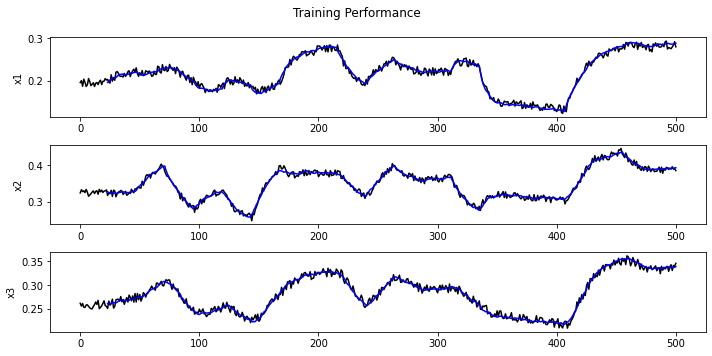

Training Performance: 
 x1 fitness: 97.637%
 x2 fitness: 97.438%
 x3 fitness: 97.537%
 Average:    97.537%
 Sim time:   0.24 sec


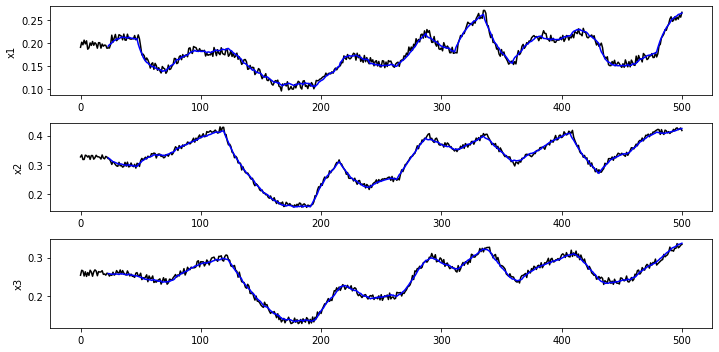

 x1 fitness: 96.579%
 x2 fitness: 99.105%
 x3 fitness: 98.483%
 Average:    98.056%
 Sim time:   0.36 sec


In [10]:
best_mdl = create_model(study.best_trial)

start = time()
y = best_mdl.predict(UY_train_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

# Plot for Training Data
plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_train)), Z_train[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+2])
    #plt.xlim([0, 200])

plt.suptitle('Training Performance')
plt.tight_layout()
plt.show()

r2 = R2_score(Z_train, y_)
print('Training Performance: ')
print(f" x1 fitness: {r2[0]*100:.3f}%")
print(f" x2 fitness: {r2[1]*100:.3f}%")
print(f" x3 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

# Plot for Validation Data
start = time()
y = best_mdl.predict(UY_valid_, verbose=0)
y_ = y[:, -1, :] * sc.scale_[YI] + sc.mean_[YI]
sim_time = time() - start

plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_valid)), Z_valid[:, YI[j]], 'k', label='Actual data')
    plt.plot(look_back + np.arange(len(y)), y_[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+2])
    #plt.xlim([0, 200])

plt.tight_layout()
plt.show()

r2 = R2_score(Z_valid, y_)
print(f" x1 fitness: {r2[0]*100:.3f}%")
print(f" x2 fitness: {r2[1]*100:.3f}%")
print(f" x3 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")

In [11]:
best_mdl.save('tanks_lstm.keras')

## Check the performance of LSTM for infinite-step ahead prediction

In [12]:
def R2_score_(Z, y_pred):
    r2 = np.zeros(len(YI))
    for k in range(len(YI)):
        y_true = Z[:, YI[k]]
        r2[k] = 1 - np.sum((y_true - y_pred[:, k]) ** 2) \
                / np.sum((y_true - np.mean(y_true)) ** 2)
    return r2

In [13]:
best_mdl = load_model('tanks_lstm.keras')

uy0 = np.array((28e-6, 28e-6, 0.1961, 0.3243, 0.26)*look_back).reshape(-1, 5)
noise = (np.random.rand(look_back, len(YI))-0.5)*np.array([0.02, 0.02, 0.02])
uy0[:, YI] = uy0[:, YI] + noise
u = Z_valid[:, UI]

def sim_mpc(lstm_mdl, uy0, u):
    # Shape of uy0: [look_back x n_u+n_y] (not scaled)
    # Shape of u:   [N_hor x n_u] (not scaled)
    
    # u includes the initial state u0

    N = u.shape[0] # This is N_hor
    y_pred = np.zeros((N, len(YI)))
    uy = (uy0 - sc.mean_) / sc.scale_
    u_ = (u - sc.mean_[UI]) / sc.scale_[UI]
    y_pred[0, :] = uy[-1, YI]
    
    for j in np.arange(1, N):
        uy = np.hstack((np.vstack((uy[1:, UI], 
                                   u_[np.minimum(j, N), :])), 
                        uy[:, YI]))
        y = lstm_mdl.predict(uy[np.newaxis, :, :], verbose=0)
        y_pred[j, :] = y[:, -1, :]
        uy = np.hstack((uy[:, UI],
                        np.vstack((uy[1:, YI], y[:, -1, :]))))
    
    y_pred = y_pred * sc.scale_[YI] + sc.mean_[YI]
    
    return y_pred

start = time()
y_pred = sim_mpc(best_mdl, uy0, u)
sim_time = time() - start
print(y_pred.shape)
print(f"Sim Time: {sim_time:.2f} sec")

(501, 3)
Sim Time: 22.68 sec


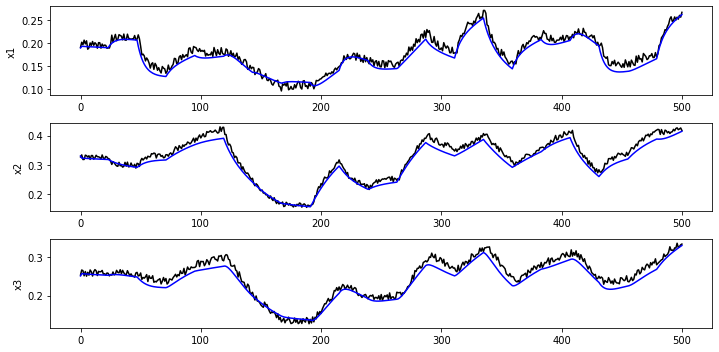

 x1 fitness: 89.849%
 x2 fitness: 93.980%
 x3 fitness: 90.683%
 Average:    91.504%
 Sim time:   22.68 sec


In [14]:
# Plot for Validation Data

plt.figure(figsize=(10, 5))
for j in range(3):
    plt.subplot(3, 1, j+1)
    plt.plot(range(len(Z_valid)), Z_valid[:, YI[j]], 'k', label='Actual data')
    plt.plot(range(len(Z_valid)), y_pred[:, j], 'b', label='LSTM pred.')
    plt.ylabel(v_name[j+2])
    #plt.xlim([0, 2])

plt.tight_layout()
plt.show()

r2 = R2_score_(Z_valid, y_pred)
print(f" x1 fitness: {r2[0]*100:.3f}%")
print(f" x2 fitness: {r2[1]*100:.3f}%")
print(f" x3 fitness: {r2[2]*100:.3f}%")
print(f" Average:    {np.mean(r2)*100:.3f}%")
print(f" Sim time:   {sim_time:.2f} sec")